In [2]:
import seaborn as sns
import torch


In [3]:
from transformers import BertConfig, BertModel, BertTokenizer
model_type = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_type)
config.output_attentions=True
model = BertModel.from_pretrained(model_type,config = config).to('cuda')
tokenizer = BertTokenizer.from_pretrained(model_type)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
text1 = 'We met today and she wanted to'
text2 = 'meet again'
tok1 = tokenizer.tokenize(text1)
tok2 = tokenizer.tokenize(text2)

In [5]:
p_pos = len(tok1) # position for token
tok = tok1+tok2
tok,p_pos, tok[p_pos]

(['we', 'met', 'today', 'and', 'she', 'wanted', 'to', 'meet', 'again'],
 7,
 'meet')

In [6]:
ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')
with torch.no_grad():
    output = model(ids)
attentions = torch.cat(output[2]).to('cpu')
attentions.shape #(layer, batch_size (squeezed by torch.cat), num_heads, sequence_length, sequence_length)

torch.Size([12, 12, 9, 9])

In [34]:
attentions = attentions.permute(2,1,0,3)
print(attentions.shape) #(sequence_length, num_heads, layer, sequence_length)


torch.Size([12, 12, 9, 9])


In [ ]:
attentions[0]

In [58]:
layers = len(attentions[0][0])
heads = len(attentions[0])
seqlen = len(attentions)
layers,heads,seqlen

(9, 12, 12)

In [59]:
attentions_pos = attentions[p_pos]
attentions_pos.shape

torch.Size([12, 9, 9])

Attention weights for token = meet


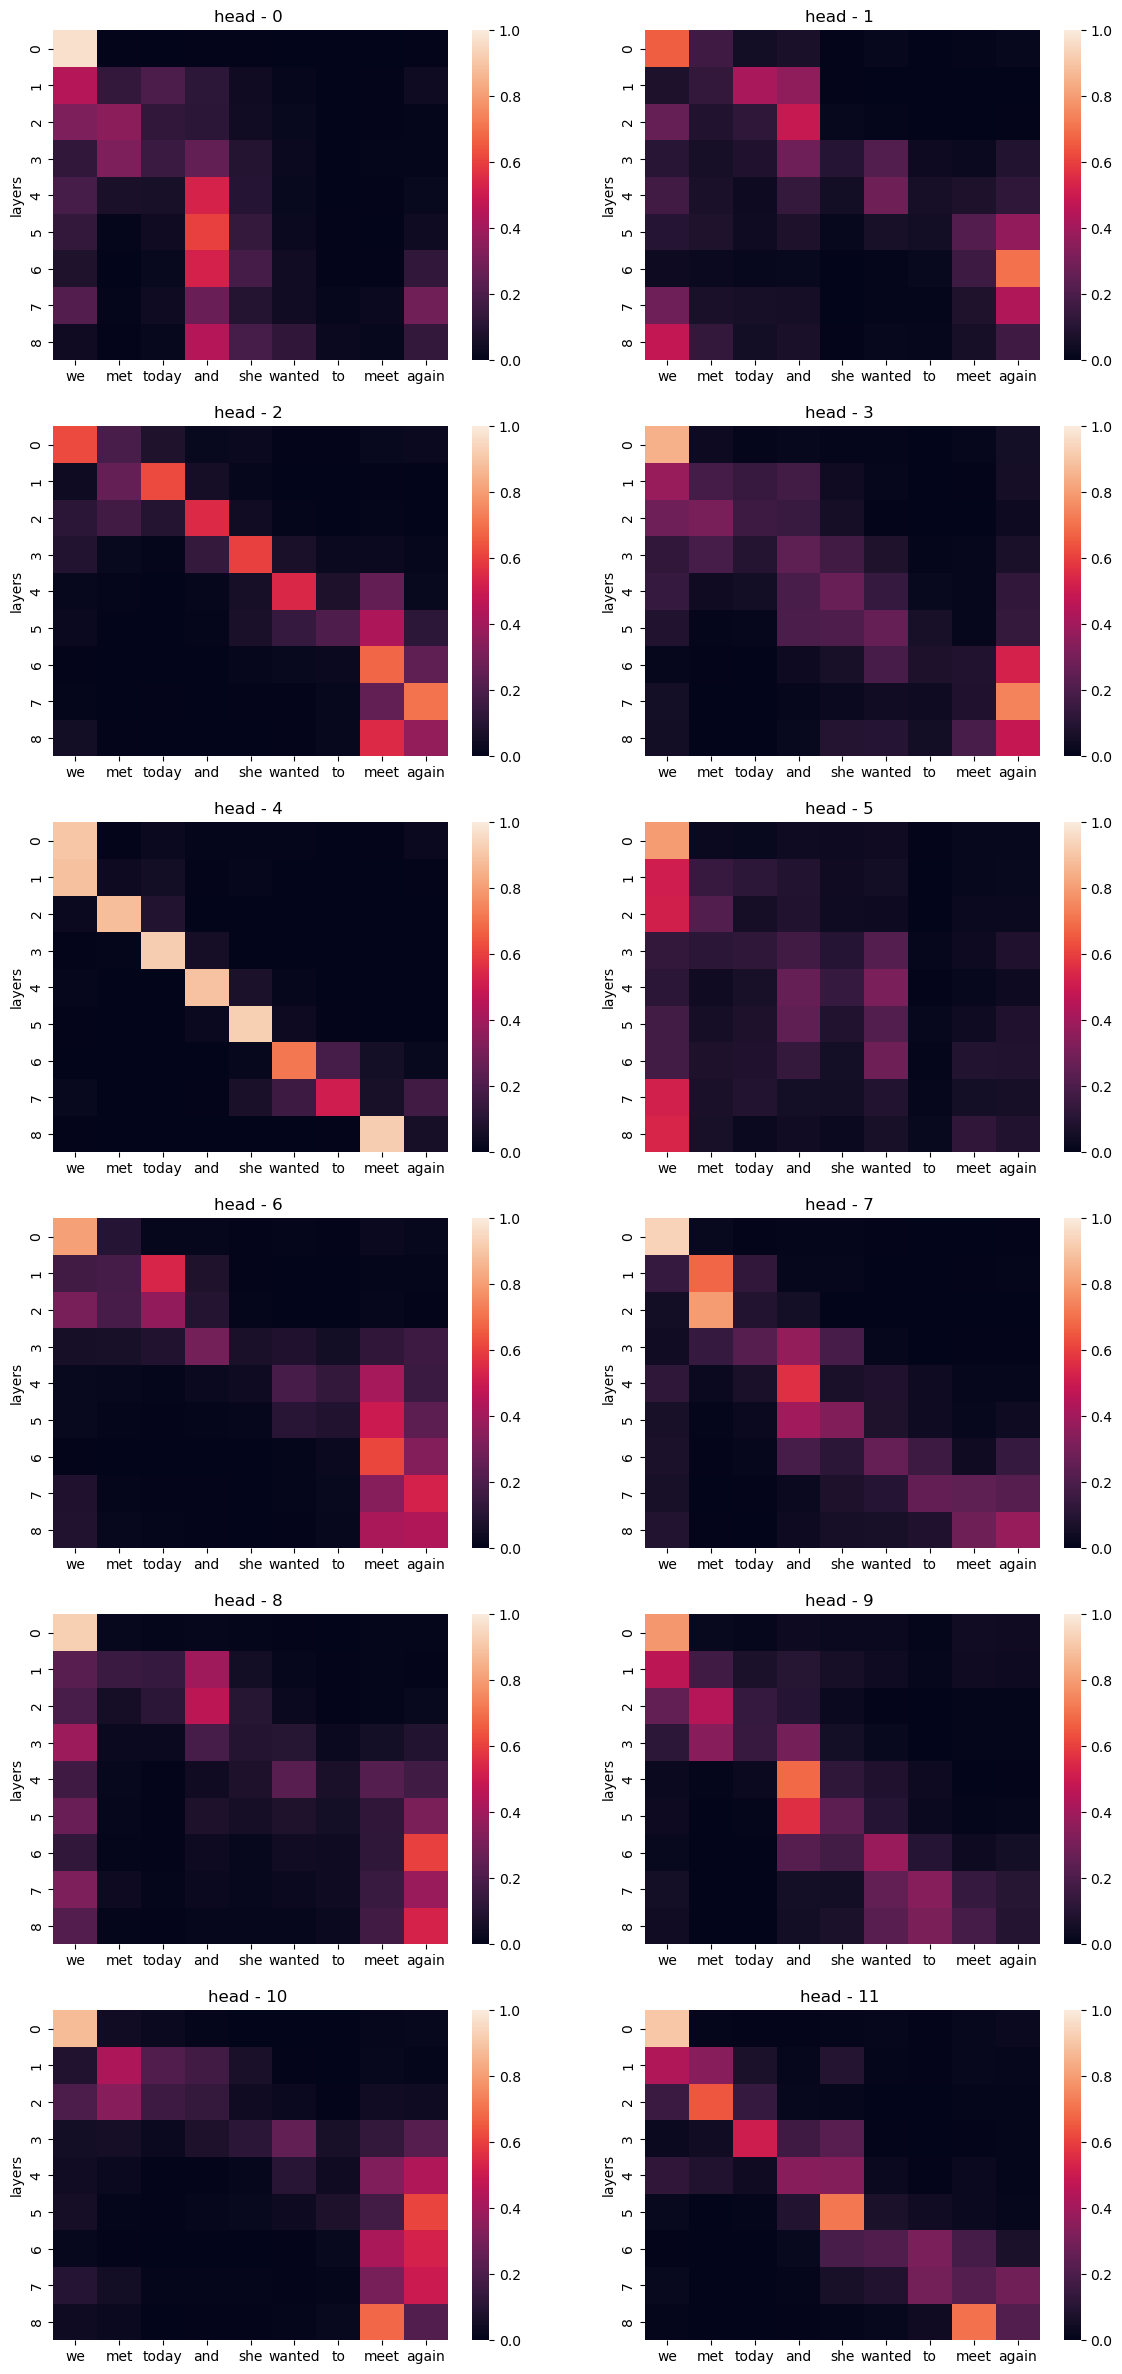

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cols = 2
rows = int(heads/cols)

fig, axes = plt.subplots( rows,cols, figsize = (14,30))
axes = axes.flat
print (f'Attention weights for token = {tok[p_pos]}')
for i,att in enumerate(attentions_pos):

    #im = axes[i].imshow(att, cmap='gray')
    sns.heatmap(att,vmin = 0, vmax = 1,ax = axes[i], xticklabels = tok)
    axes[i].set_title(f'head - {i} ' )
    axes[i].set_ylabel('layers')

<Axes: >

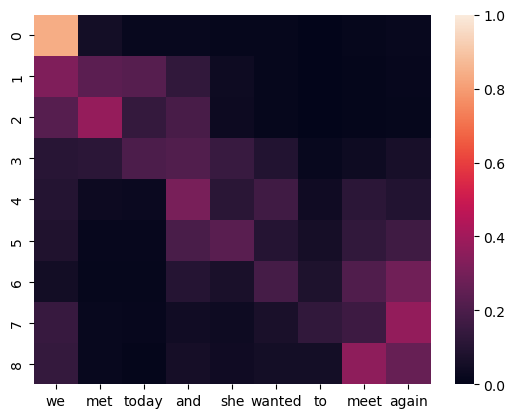

In [62]:
avg_attention = attentions_pos.mean(dim = 0)
sns.heatmap(avg_attention,vmin = 0, vmax = 1, xticklabels= tok, )